# Building a semantic segmentation algorithm

This notebook is based on Francois Chollet, "Deep Learning with Python". The idea is to build an image segmentation algorithm. There are not many publicly available datasets for this task. One of the few ones is the [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), which contains images 37 (pet) categories.

In [9]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

First, we load the dataset and sort the images and annotations into folders.

In [23]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

/bin/bash: wget: command not found
/bin/bash: wget: command not found
tar: Error opening archive: Failed to open 'images.tar.gz'
tar: Error opening archive: Failed to open 'annotations.tar.gz'


In [24]:
input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

FileNotFoundError: [Errno 2] No such file or directory: 'images/'

We can then take a look at examples. First, the original image

NameError: name 'input_img_paths' is not defined

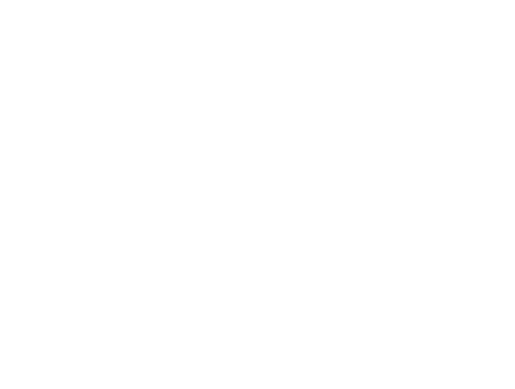

In [12]:
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

Second, the annotation. Note that each pixel is annotated with a corresponding class.

In [13]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

NameError: name 'target_paths' is not defined

We now convert the images into numpy arrays that we will use for training and testing

In [14]:
img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

NameError: name 'input_img_paths' is not defined

Take a look at the dimensions:

In [15]:
print(train_input_imgs.shape)
print(train_targets.shape)

NameError: name 'train_input_imgs' is not defined

In particular, each "target" is a two-dimensional map of classes with the same size as the input image. For each input pixel (which comes in three colors, that's why there are three channels in the input), there is exactly one class (this is why there is only one channel).

We now create our initial model. The first part is a "normal" CNN that takes our input and creates an encoding, by "downsampling" our input, that is, by going from the full 200x200 image with three channels to a final convolutional layer with dimensions 25x25 and 256 channels.

The second part is where things get more interesting. This "upsamples" our encoding, to recreate a 2D-output (basically the same image as before, just a schematic version, where pixels are classes rather than actual pixels). Upsampling happens with `Conv2DTranspose` layers, which basically invert what the `Conv2D` layers do.

We are creating an encoding from an input, then decoding this encoding into an output of the same dimensions as the original input. Does this sound familiar?

In [16]:
def get_model(img_size, num_classes):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=img_size + (3,)),
        layers.Rescaling(1./255),
        layers.Conv2D(64, 3, strides=2, activation="relu", padding="same"),
        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.Conv2D(128, 3, strides=2, activation="relu", padding="same"),
        layers.Conv2D(128, 3, activation="relu", padding="same"),
        layers.Conv2D(256, 3, strides=2, padding="same", activation="relu"),
        layers.Conv2D(256, 3, activation="relu", padding="same"),
        
        layers.Conv2DTranspose(256, 3, activation="relu", padding="same"),
        layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2),
        layers.Conv2DTranspose(128, 3, activation="relu", padding="same"),
        layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2),
        layers.Conv2DTranspose(64, 3, activation="relu", padding="same"),
        layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2),
        layers.Conv2D(num_classes, 3, activation="softmax", padding="same")])
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-27 14:32:42.644681: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-27 14:32:42.644814: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 256)       5

**Question 1**: In your own words, explain what type of model we are creating here. What is the key difference to other models of this type that we have seen so far?

**Question 2**: You might notice that we are not using MaxPooling to "downsample" (that is, to reduce the size of the layers while increasing the number of channels). Rather, we added strides >1 to our convolutions. Why do you think this is?

We next compile and train the model. Note that it will take very long without a GPU, so Colab is recommended. However, you will eventually run out of memory on Colab, so your session will crash. Hence, I highly recommend saving the best model so far (this is already handled with the `ModelCheckpoint`), then starting from that model and keeping on training in a new session. Hence, once your initial model has been created and trained for a few epochs, you can instead use

`model = tf.keras.models.load_model("oxford_segmentation")`.

In [17]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("oxford_segmentation",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=30,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

NameError: name 'train_input_imgs' is not defined

**Question 3**: Why do you think are we using `"sparse_categorical_crossentropy"` as a loss function?

Let's take a look at the predictions made by our model:

In [18]:
model = tf.keras.models.load_model("oxford_segmentation")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

OSError: No file or directory found at oxford_segmentation

In [19]:
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

NameError: name 'test_image' is not defined

**Question 4**: U-Net is a model designed for image segmentation. One of the ideas is to have residual connections between downsampling and upsampling blocks (see also the video materials). Can you improve the performance by adding such residual connections to the model above? Note that you will have to use the Functional API to make this work, as in the tutorial.

**Question 5**: Can you do better using transfer learning? There are two approaches:

1. Use a [pre-trained semantic segmentation model from the TensorFlow hub](https://tfhub.dev/s?module-type=image-segmentation). The advantage is that the models come out-of the box. The disadvantage is that these are user-generated, so they are a bit harder to implement and they may not be trained on data that has a lot of resemblence to pet-pictures.
1. Build a "U-Net"-like model (see the video materials), by using a pre-made CNN for encoding (a standard one such as Xception or VGG19 should do the trick), and adding a decoding part, including residual connections.

When training the models on your data, make sure to freeze as much as possible.

Note: neither option is very straightforward. You do not need to have a complete and working network to pass the Bonus Assignment. Instead, your code has to show that you have understood the approach you are attempting and are on the right track.